In [1]:
# 数据处理和分析库
import pandas as pd
import numpy as np

# 可视化库
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sys
sys.path.append("../../psap_utils")
from psap_utils import find_best_params_average
from psap_utils import print_results_in_separate_lines
from metrics import weighted_balanced_accuracy, balanced_accuracy, sensitivity, specificity, ppv, npv, plr, nlr, post_test_prob
# 机器学习模型库
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# 其他工具库
import warnings
warnings.filterwarnings('ignore')
import re
import pickle
import os
import time
from datetime import datetime
from joblib import Parallel, delayed

# 评估和模型选择库
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_auc_score, make_scorer, accuracy_score, f1_score, fbeta_score, matthews_corrcoef, balanced_accuracy_score, brier_score_loss, class_likelihood_ratios


In [2]:
with open('b_rac_all_best_params.pkl', 'rb') as f:
    all_best_params = pickle.load(f)

In [3]:
with open('b_rac_splits.pkl', 'rb') as f:
    datasets = pickle.load(f)

In [4]:
models = [
    ("LR", LogisticRegression(max_iter=400), {
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l2', 'none']
    }),
    ("SVM", SVC(probability=True), {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
        'kernel': ['linear', 'rbf', 'poly']
    }),
    ("RF", RandomForestClassifier(criterion='gini', min_samples_split=2, bootstrap=True), {
        'n_estimators': [50, 100, 150, 200], 
        'max_depth': [3, 4, 5]
    }),
    ("XGB", XGBClassifier(booster='gbtree'), {
        'n_estimators': [50, 100, 150, 200], 
        'max_depth': [3, 4, 5], 
        'learning_rate': [0.001, 0.01, 0.1]
    }),
    ("ANN", MLPClassifier(hidden_layer_sizes=(42, 21,), early_stopping=False), {
        'hidden_layer_sizes': [(42, 21,), (21, 14,), (42, 21, 14,)],
        'activation': ['tanh'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.001, 0.01, 0.1],
        'learning_rate': ['adaptive'],
        'max_iter': [200, 300, 400]
    })]

In [5]:
unique_parameters = {}

# Extracting and deduplicating parameters
for model_name, metrics in all_best_params.items():
    for metric, content in metrics.items():
        params = content['best_params']
        if model_name not in unique_parameters:
            unique_parameters[model_name] = set()  # Initialize as a new set
        unique_parameters[model_name].add(frozenset(params.items()))  # Now you can safely add the items

In [6]:
from sklearn.base import clone  # 用于复制模型实例

# 初始化字典，每个模型名对应一个空列表
configured_models = {model_name: [] for model_name, _, _ in models}

for model_name, model_instance, _ in models:
    # 检查确保有为该模型定义的唯一参数
    if model_name in unique_parameters:
        for param in unique_parameters[model_name]:
            # 复制原始模型实例以避免修改它
            model_copy = clone(model_instance)
            
            # 更新模型参数
            model_copy.set_params(**dict(param))  # 将 frozenset 转换为字典
            
            # 将配置过的模型实例添加到列表中
            configured_models[model_name].append(model_copy)

In [7]:
data = pd.read_csv('../../data/data_rac.csv')
y = data['RAC'].apply(lambda x: 0 if x == 0 else 1)
prevalence = y.sum()/y.shape[0]

In [9]:
prevalence 

0.5703215807826424

In [8]:
scoring= {
    'sen': make_scorer(sensitivity),
    'spe': make_scorer(specificity),
    'ppv': make_scorer(ppv),
    'npv': make_scorer(npv),
    'plr': make_scorer(plr),
    'nlr': make_scorer(nlr),
    'ptp': make_scorer(post_test_prob),
    'acc': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score, needs_proba=True),
    'mcc': make_scorer(matthews_corrcoef),
    'wba': make_scorer(weighted_balanced_accuracy),
    'ba': make_scorer(balanced_accuracy_score),
    'f1': make_scorer(f1_score),
    'bs': make_scorer(brier_score_loss,greater_is_better=False)
}

In [9]:
import numpy as np
from scipy import stats
from tqdm import tqdm  # Make sure you have tqdm installed

results_std_ci = {}

# Assuming 'datasets' is a list of all datasets, where each dataset is a dictionary containing 'X_train', 'y_train', 'X_test', 'y_test'.
for model_name, model_list in configured_models.items():
    for index, model in enumerate(tqdm(model_list, desc=f"Processing {model_name}", leave=True)):
        unique_model_name = f"{model_name}: model{index + 1}"  # Creating a unique name for each model instance
        scores = {key: [] for key in scoring}

        for dataset in tqdm(datasets, desc=f"Evaluating {unique_model_name}", leave=False):
            X_train, y_train, X_test, y_test = dataset['X_train'], dataset['y_train'], dataset['X_test'], dataset['y_test']

            # Train the model and make predictions
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

            for name, scorer in scoring.items():
                if 'auc' in name:
                    score_value = scorer._score_func(y_test, y_proba, **scorer._kwargs)
                elif 'bs' in name:
                    score_value = scorer._score_func(y_test, y_proba, **scorer._kwargs)
                elif 'ptp' in name:
                    score_value = scorer._score_func(y_test, y_pred, prevalence, **scorer._kwargs)
                else:
                    score_value = scorer._score_func(y_test, y_pred, **scorer._kwargs)

                scores[name].append(score_value)

        # New part: Calculate standard deviation, mean, and 95% CI for each scoring metric
        statistics = {}
        for key, value in scores.items():
            # 打印原始分数，检查是否有nan
            #print(f"Raw scores for {key}: {value}")

            # 如果有nan值，np.nanmean 和 np.nanstd 会忽略它们，但如果所有值都是nan，则结果也会是nan
            mean_score = np.nanmean(value)
            std_dev = np.nanstd(value, ddof=1)  # 使用 ddof=1 计算样本标准差

            # 检查样本大小和自由度
            sample_size = len(value)
            degrees_freedom = sample_size - 1
            confidence_level = 0.95
            #print(f"Sample size: {sample_size}, Degrees of freedom: {degrees_freedom}")

            # 检查标准误是否为零或nan（如果是，这将是一个问题）
            standard_error = std_dev / np.sqrt(sample_size)
            #print(f"Standard error for {key}: {standard_error}")

            if degrees_freedom > 0 and not np.isnan(standard_error):
                confidence_interval = stats.t.interval(confidence_level, degrees_freedom, loc=mean_score, scale=standard_error)
            else:
                #print(f"Skipping confidence interval calculation for {key} due to insufficient data.")
                confidence_interval = (np.nan, np.nan)

            # 存储统计数据
            statistics[key] = {
                'mean': mean_score,
                'std_dev': std_dev,
                '95%_CI': confidence_interval
            }

        # Store the results in the 'results' dictionary, using the unique name of the model as the key
        results_std_ci[unique_model_name] = statistics

# The 'results' dictionary now contains the scores and their statistics for each model instance, each with a unique name.


Processing SVM:  67%|████████████████████████████████████████████▋                      | 2/3 [05:38<02:49, 169.30s/it]


KeyboardInterrupt: 

In [12]:
import numpy as np
from scipy import stats
from joblib import Parallel, delayed

def evaluate_model_on_dataset(model, dataset, scoring):
    X_train, y_train, X_test, y_test = dataset['X_train'], dataset['y_train'], dataset['X_test'], dataset['y_test']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class

    scores = {}
    for name, scorer in scoring.items():
        if 'auc' in name:
            score_value = scorer._score_func(y_test, y_proba, **scorer._kwargs)
        elif 'bs' in name:
            score_value = scorer._score_func(y_test, y_proba, **scorer._kwargs)
        elif 'ptp' in name:
            score_value = scorer._score_func(y_test, y_pred, prevalence, **scorer._kwargs)
        else:
            score_value = scorer._score_func(y_test, y_pred, **scorer._kwargs)
        scores[name] = score_value
    return scores

def calculate_statistics(scores):
    statistics = {}
    for key, value in scores.items():
        mean_score = np.nanmean(value)
        std_dev = np.nanstd(value, ddof=1)
        sample_size = len(value)
        degrees_freedom = sample_size - 1
        confidence_level = 0.95
        standard_error = std_dev / np.sqrt(sample_size)
        if degrees_freedom > 0 and not np.isnan(standard_error):
            confidence_interval = stats.t.interval(confidence_level, degrees_freedom, loc=mean_score, scale=standard_error)
        else:
            confidence_interval = (np.nan, np.nan)
        statistics[key] = {'mean': mean_score, 'std_dev': std_dev, '95%_CI': confidence_interval}
    return statistics

model_scores = {}
results_std_ci = {}

n_jobs = -1  # This will use all available CPUs

for model_name, model_list in configured_models.items():
    for index, model in enumerate(model_list):
        unique_model_name = f"{model_name}: model{index + 1}"
        # Parallel execution
        all_scores = Parallel(n_jobs=n_jobs)(delayed(evaluate_model_on_dataset)(model, dataset, scoring) for dataset in datasets)
        # Combine scores for each metric
        combined_scores = {key: [d[key] for d in all_scores if key in d] for key in scoring}
        model_scores[unique_model_name] = combined_scores
        results_std_ci[unique_model_name] = calculate_statistics(combined_scores)

# The 'results_std_ci' dictionary now contains the statistics for each model instance.


In [18]:
with open('b_rac_results_std_ci.pkl', 'wb') as f:
    pickle.dump(results_std_ci, f)

In [11]:
with open('b_rac_results_std_ci.pkl', 'rb') as f:
    results_std_ci = pickle.load(f)

In [10]:
with open('b_rac_results_std_ci.pkl', 'rb') as f:
    results_std_ci = pickle.load(f)

In [11]:
with open('b_rac_model_scores.pkl', 'rb') as f:
    model_scores = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'b_rac_model_scores.pkl'

In [13]:
rows = []
for model, indicators in results_std_ci.items():
    for indicator, stats in indicators.items():
        row = {
            "model": model,
            "indicator": indicator,
            "mean": stats["mean"],
            "std_dev": stats["std_dev"],
            "CI_lower": stats["95%_CI"][0],
            "CI_upper": stats["95%_CI"][1]
        }
        rows.append(row)

In [ ]:
df = pd.DataFrame(rows)

# 保存为Excel文件
excel_path = 'model_performance_rac_without_OF_OFsite.xlsx'
df.to_excel(excel_path, index=False)

In [14]:
# 第一步：确定每种模型类型的最佳MCC值
best_mcc_models = {}
for row in rows:
    model_type, model_name = row["model"].split(":")[0], row["model"]
    if row["indicator"] == "mcc":
        mcc = row["mean"]
        if model_type not in best_mcc_models or mcc > best_mcc_models[model_type]["best_mcc"]:
            best_mcc_models[model_type] = {"best_mcc": mcc, "model_name": model_name}

# 第二步：根据最佳MCC模型名，从 results_std_ci 提取相关统计数据
final_results = {}
final_scores = {}
for model_type in best_mcc_models:
    model_name = best_mcc_models[model_type]["model_name"]
    if model_name in results_std_ci:
        final_results[model_name] = results_std_ci[model_name]
        final_scores[model_name] = model_scores[model_name]

        

In [15]:
with open('b_rac_final_results.pkl', 'wb') as f:
    pickle.dump(final_results, f)

In [16]:
with open('b_rac_final_scores.pkl', 'wb') as f:
    pickle.dump(final_scores, f)

In [17]:
final_scores.keys()

dict_keys(['LR: model1', 'SVM: model3', 'RF: model1', 'XGB: model3', 'ANN: model2'])

In [19]:
final_scores

{'LR: model1': {'sen': [0.7608695652173914,
   0.7554347826086957,
   0.7907608695652174,
   0.7853260869565217,
   0.7228260869565217,
   0.7880434782608695,
   0.7418478260869565,
   0.7690217391304348,
   0.7608695652173914,
   0.7364130434782609],
  'spe': [0.8992805755395683,
   0.9172661870503597,
   0.89568345323741,
   0.8848920863309353,
   0.9424460431654677,
   0.8992805755395683,
   0.8812949640287769,
   0.8776978417266187,
   0.9064748201438849,
   0.9028776978417267],
  'ppv': [0.9090909090909091,
   0.9235880398671097,
   0.909375,
   0.9003115264797508,
   0.9432624113475178,
   0.9119496855345912,
   0.8921568627450981,
   0.8927444794952681,
   0.9150326797385621,
   0.9093959731543624],
  'npv': [0.7396449704142012,
   0.7391304347826086,
   0.7638036809815951,
   0.7569230769230769,
   0.7197802197802198,
   0.7621951219512195,
   0.7205882352941176,
   0.7416413373860182,
   0.7411764705882353,
   0.7212643678160919],
  'plr': [7.554347826086954,
   9.130907372400

In [18]:
import scipy.stats as stats
from itertools import combinations

# Storing the results of paired t-tests for all model combinations
all_paired_t_test_results = {}

# Getting the list of all model names
model_names = list(final_scores.keys())

# Setting the significance level
alpha = 0.05

# Define the order of indicators
indicator_order = ['sen', 'spe', 'ppv', 'npv', 'plr', 'nlr', 'ptp', 'acc', 'auc', 'mcc', 'wba', 'ba', 'f1', 'bs']

# Iterating through all possible combinations of models
for model1, model2 in combinations(model_names, 2):
    paired_t_test_results = {}

    # Getting the score data for these two models
    model1_scores = final_scores[model1]
    model2_scores = final_scores[model2]

    # Ensuring both models have the same set of indicators
    common_indicators = set(model1_scores.keys()).intersection(set(model2_scores.keys()))

    # Performing paired t-test for each common indicator
    for indicator in indicator_order:
        if indicator in common_indicators:
            scores_model1 = model1_scores[indicator]
            scores_model2 = model2_scores[indicator]

            # Conducting the paired t-test
            t_statistic, p_value = stats.ttest_rel(scores_model1, scores_model2)
            paired_t_test_results[indicator] = {'t_statistic': t_statistic, 'p_value': p_value}

    # Adding the results to the overall results dictionary
    all_paired_t_test_results[(model1, model2)] = paired_t_test_results

# Outputting the results, including significance judgment
for models, results in all_paired_t_test_results.items():
    print(f"Model Comparison: {models[0]} vs {models[1]}")
    for indicator in indicator_order:
        if indicator in results:
            result = results[indicator]
            print(f"  Indicator {indicator}: t-statistic = {result['t_statistic']}, p-value = {result['p_value']}")

            # Judging the significance
            if result['p_value'] <= alpha:
                print(f"    --> Result: Significant difference (p-value ≤ {alpha})")
                # Special handling for 'bs' where lower is better
                if indicator == 'bs':
                    better_model = models[1] if result['t_statistic'] > 0 else models[0]
                else:
                    better_model = models[0] if result['t_statistic'] > 0 else models[1]

                print(f"    Interpretation: {better_model} performs better on {indicator}.")
            else:
                print(f"    Result: No significant difference (p-value > {alpha})")
    print("\n")



Model Comparison: LR: model1 vs SVM: model3
  Indicator sen: t-statistic = 15.729260585107516, p-value = 7.464461823272207e-08
    --> Result: Significant difference (p-value ≤ 0.05)
    Interpretation: LR: model1 performs better on sen.
  Indicator spe: t-statistic = -14.259742247413032, p-value = 1.749429833540046e-07
    --> Result: Significant difference (p-value ≤ 0.05)
    Interpretation: SVM: model3 performs better on spe.
  Indicator ppv: t-statistic = -14.322408739876753, p-value = 1.6842830635399733e-07
    --> Result: Significant difference (p-value ≤ 0.05)
    Interpretation: SVM: model3 performs better on ppv.
  Indicator npv: t-statistic = 10.455524213680524, p-value = 2.466719877670625e-06
    --> Result: Significant difference (p-value ≤ 0.05)
    Interpretation: LR: model1 performs better on npv.
  Indicator plr: t-statistic = -6.489889730255915, p-value = 0.00011276963639086266
    --> Result: Significant difference (p-value ≤ 0.05)
    Interpretation: SVM: model3 per

In [19]:
from scipy.stats import ttest_rel
import pandas as pd

best_configurations = {}

# 对每个模型执行分析
for model_name in set(model_name for model_name, _, _ in models):
    model_scores = {metric: [] for metric in scoring.keys()}
    configurations = []

    # 提取性能数据
    for unique_model_name, metrics in results_std_ci.items():
        if model_name in unique_model_name:
            configurations.append(unique_model_name)
            for metric, values in metrics.items():
                model_scores[metric].append(values['mean'])

    # 将数据转换为 DataFrame，方便处理
    df_scores = pd.DataFrame(model_scores, index=configurations)

    # 进行成对 t-检验，并记录 p-值
    p_values = pd.DataFrame(index=df_scores.index, columns=df_scores.index)
    for i in range(len(df_scores)):
        for j in range(i+1, len(df_scores)):
            for metric in df_scores.columns:
                _, p_val = ttest_rel(df_scores.iloc[i][metric], df_scores.iloc[j][metric], nan_policy='omit')
                p_values.at[df_scores.index[i], df_scores.index[j]] = p_val

    # 选择性能最佳的配置
    # 这可以通过比较每个配置的平均排名来完成
    rank_sum = df_scores.rank().sum(axis=1)
    best_configuration = rank_sum.idxmin()

    best_configurations[model_name] = best_configuration

# 更新 configured_models 以只包含最佳配置
for model_name in list(configured_models.keys()):
    if model_name in best_configurations:
        best_model_name = best_configurations[model_name]
        configured_models[model_name] = [model for model in configured_models[model_name] if best_model_name in str(model)]

# 现在 configured_models 只包含每种基础模型的最佳配置


In [14]:
results_std_ci

{'LR: model1': {'sen': {'mean': 0.7611413043478261,
   'std_dev': 0.022931161996423033,
   '95%_CI': (0.7447373392521677, 0.7775452694434846)},
  'spe': {'mean': 0.9007194244604315,
   'std_dev': 0.01897365989913908,
   '95%_CI': (0.887146485820387, 0.914292363100476)},
  'ppv': {'mean': 0.9106907567453171,
   'std_dev': 0.015007255653163472,
   '95%_CI': (0.8999552127744308, 0.9214263007162034)},
  'npv': {'mean': 0.7406147915917385,
   'std_dev': 0.01661154152935033,
   '95%_CI': (0.7287316106401998, 0.7524979725432772)},
  'plr': {'mean': 7.972659006156784,
   'std_dev': 1.82687723231202,
   '95%_CI': (6.6657897616948585, 9.279528250618709)},
  'nlr': {'mean': 0.2650371624001587,
   'std_dev': 0.02286831547461601,
   '95%_CI': (0.24867815499789003, 0.2813961698024273)},
  'ptp': {'mean': 0.910909687720111,
   'std_dev': 0.014973514702146314,
   '95%_CI': (0.9001982805715483, 0.9216210948686738)},
  'acc': {'mean': 0.8212074303405572,
   'std_dev': 0.011024695881951227,
   '95%_CI': 

In [22]:
# 首先打印 configured_models 中的每个模型的配置数量
for model_name, model_instances in configured_models.items():
    print(f"{model_name}: {len(model_instances)} instances")

# 接着，检查 results_std_ci 字典中模型实例的数量
print("\nNumber of unique model instances in results_std_ci:", len(results_std_ci))


LR: 2 instances
SVM: 3 instances
RF: 1 instances
XGB: 5 instances
ANN: 3 instances

Number of unique model instances in results_std_ci: 14


In [23]:
# 打印 results_std_ci 中的每个唯一模型名称及其对应的性能统计数据的简要概述
for unique_model_name, statistics in results_std_ci.items():
    print(f"{unique_model_name}:")
    for metric, stats in statistics.items():
        print(f"  {metric}: Mean = {stats['mean']}, 95% CI = {stats['95%_CI']}")
    print("\n")


LR: model1:
  sen: Mean = 0.7611413043478261, 95% CI = (0.7447373392521677, 0.7775452694434846)
  spe: Mean = 0.9007194244604315, 95% CI = (0.887146485820387, 0.914292363100476)
  ppv: Mean = 0.9106907567453171, 95% CI = (0.8999552127744308, 0.9214263007162034)
  npv: Mean = 0.7406147915917385, 95% CI = (0.7287316106401998, 0.7524979725432772)
  plr: Mean = 7.972659006156784, 95% CI = (6.6657897616948585, 9.279528250618709)
  nlr: Mean = 0.2650371624001587, 95% CI = (0.24867815499789003, 0.2813961698024273)
  ptp: Mean = 0.910909687720111, 95% CI = (0.9001982805715483, 0.9216210948686738)
  acc: Mean = 0.8212074303405572, 95% CI = (0.8133208380053765, 0.829094022675738)
  auc: Mean = 0.9026479903034096, 95% CI = (0.8982522026550407, 0.9070437779517785)
  mcc: Mean = 0.6565601267770683, 95% CI = (0.6422477135560287, 0.6708725399981079)
  wba: Mean = 0.8076673443853613, 95% CI = (0.7983741551146122, 0.8169605336561103)
  ba: Mean = 0.8309303644041289, 95% CI = (0.8236561391618354, 0.8382

In [31]:
from scipy.stats import ttest_rel
import pandas as pd

best_configurations = {}

# 对每个模型执行分析
for model_name in set(model_name for model_name, _, _ in models):
    model_scores = {metric: [] for metric in scoring.keys()}
    configurations = []

    # 提取性能数据
    for unique_model_name, metrics in results_std_ci.items():
        if model_name in unique_model_name:
            configurations.append(unique_model_name)
            for metric, values in metrics.items():
                model_scores[metric].append(values['mean'])

    # 将数据转换为 DataFrame，方便处理
    df_scores = pd.DataFrame(model_scores, index=configurations)

    # 进行成对 t-检验，并记录 p-值
    p_values = pd.DataFrame(index=df_scores.index, columns=df_scores.index)
    for i in range(len(df_scores)):
        for j in range(i+1, len(df_scores)):
            for metric in df_scores.columns:
                _, p_val = ttest_rel(df_scores.iloc[i][metric], df_scores.iloc[j][metric], nan_policy='omit')
                p_values.at[df_scores.index[i], df_scores.index[j]] = p_val

    # 选择性能最佳的配置
    # 这可以通过比较每个配置的平均排名来完成
    rank_sum = df_scores.rank().sum(axis=1)
    best_configuration = rank_sum.idxmin()

    best_configurations[model_name] = best_configuration

# 更新 configured_models 以只包含最佳配置
for model_name in list(configured_models.keys()):
    if model_name in best_configurations:
        best_model_name = best_configurations[model_name]
        configured_models[model_name] = [model for model in configured_models[model_name] if best_model_name in str(model)]

# 现在 configured_models 只包含每种基础模型的最佳配置


In [32]:
configured_models

{'LR': [], 'SVM': [], 'RF': [], 'XGB': [], 'ANN': []}

In [14]:
import pandas as pd

# Convert the nested dictionary into a DataFrame with a MultiIndex
df_columns = pd.MultiIndex.from_product([list(results_std_ci.keys()), ['mean', 'std_dev', '95% CI Low', '95% CI High']],
                                        names=['Model', 'Statistic'])

# Extracting metrics names; they are the same for all models, so we can take the first
metrics_names = list(results_std_ci[list(results_std_ci.keys())[0]].keys())

# Create a DataFrame with appropriate indices, all initially empty
df = pd.DataFrame(index=metrics_names, columns=df_columns)

# Filling in the DataFrame
for model, metrics in data.items():
    for metric, values in metrics.items():
        # Populate the DataFrame with the corresponding values
        df.loc[metric, (model, 'mean')] = values['mean']
        df.loc[metric, (model, 'std_dev')] = values['std_dev']
        df.loc[metric, (model, '95% CI Low')] = values['95%_CI'][0]
        df.loc[metric, (model, '95% CI High')] = values['95%_CI'][1]

# Save to Excel
excel_file_path = 'models_performance.xlsx'
df.to_excel(excel_file_path)

excel_file_path  # This is the file path to the saved Excel file


TypeError: 'int' object is not subscriptable

In [19]:
results_std_ci

{'LR: model1': {'sen': {'mean': 0.7611413043478261,
   'std_dev': 0.022931161996423033,
   '95%_CI': (0.7447373392521677, 0.7775452694434846)},
  'spe': {'mean': 0.9007194244604315,
   'std_dev': 0.01897365989913908,
   '95%_CI': (0.887146485820387, 0.914292363100476)},
  'ppv': {'mean': 0.9106907567453171,
   'std_dev': 0.015007255653163472,
   '95%_CI': (0.8999552127744308, 0.9214263007162034)},
  'npv': {'mean': 0.7406147915917385,
   'std_dev': 0.01661154152935033,
   '95%_CI': (0.7287316106401998, 0.7524979725432772)},
  'plr': {'mean': 7.972659006156784,
   'std_dev': 1.82687723231202,
   '95%_CI': (6.6657897616948585, 9.279528250618709)},
  'nlr': {'mean': 0.2650371624001587,
   'std_dev': 0.02286831547461601,
   '95%_CI': (0.24867815499789003, 0.2813961698024273)},
  'ptp': {'mean': 0.910909687720111,
   'std_dev': 0.014973514702146314,
   '95%_CI': (0.9001982805715483, 0.9216210948686738)},
  'acc': {'mean': 0.8212074303405572,
   'std_dev': 0.011024695881951227,
   '95%_CI': 

In [15]:
rows = []
for model, indicators in results_std_ci.items():
    for indicator, stats in indicators.items():
        row = {
            "model": model,
            "indicator": indicator,
            "mean": stats["mean"],
            "std_dev": stats["std_dev"],
            "CI_lower": stats["95%_CI"][0],
            "CI_upper": stats["95%_CI"][1]
        }
        rows.append(row)

df = pd.DataFrame(rows)

# 保存为Excel文件
excel_path = 'model_performance.xlsx'
df.to_excel(excel_path, index=False)

In [16]:
# 创建具有多级列的数据结构
data_for_multiindex = {}
for model, indicators in results_std_ci.items():
    for indicator, stats in indicators.items():
        # 制作键名，结合模型名和指标名
        key_name = (model, indicator)
        data_for_multiindex[key_name] = {
            ("mean",): stats["mean"],
            ("std_dev",): stats["std_dev"],
            ("95%_CI", "lower"): stats["95%_CI"][0],
            ("95%_CI", "upper"): stats["95%_CI"][1],
        }

# 准备转换为DataFrame的数据
multi_index_data = {}
for key, value_dict in data_for_multiindex.items():
    for stats_key, stat_value in value_dict.items():
        # 检查键是否已存在
        if stats_key not in multi_index_data:
            multi_index_data[stats_key] = {}
        # 添加值
        multi_index_data[stats_key][key] = stat_value

# 创建多级索引DataFrame
multi_index_df = pd.DataFrame(multi_index_data)

# 由于Pandas在保存时将扁平化多级索引，我们在此处转置DataFrame以保持所需的格式
multi_index_df = multi_index_df.T

# 保存具有多级列的DataFrame
excel_multiindex_path = 'model_performance_multiindex.xlsx'
with pd.ExcelWriter(excel_multiindex_path) as writer:
    multi_index_df.to_excel(writer, index=True)


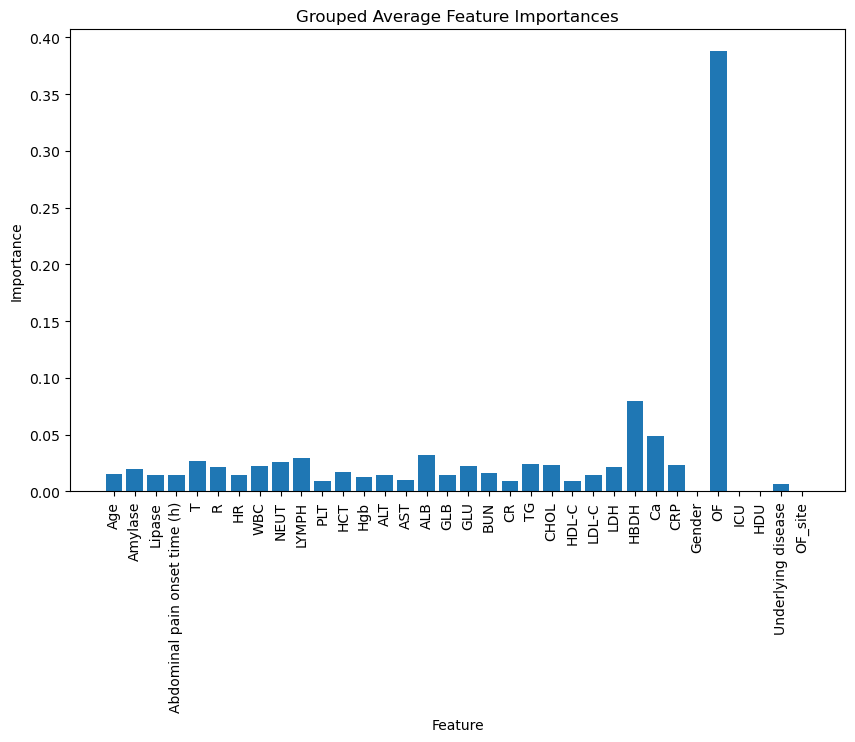

In [10]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

model = XGBClassifier(booster='gbtree', learning_rate=0.1, max_depth=3, n_estimators=50)
sum_feature_importances = None
feature_names = None

for dataset in datasets:
    X_train, y_train, X_test, y_test = dataset['X_train'], dataset['y_train'], dataset['X_test'], dataset['y_test']

    # Train the model
    model.fit(X_train, y_train)

    # Initialize feature names and sum_feature_importances
    if feature_names is None:
        feature_names = X_train.columns
        sum_feature_importances = np.zeros(len(feature_names))

    # Sum the feature importances
    sum_feature_importances += model.feature_importances_

# Calculate the average feature importances
average_feature_importances = sum_feature_importances / len(datasets)

# Group the feature importances of one-hot encoded features
grouped_importances = {}
for name, importance in zip(feature_names, average_feature_importances):
    if 'Underlying disease_' in name:
        base_name = 'Underlying disease'
        grouped_importances[base_name] = grouped_importances.get(base_name, 0) + importance
    elif 'OF_site_' in name:
        base_name = 'OF_site'
        grouped_importances[base_name] = grouped_importances.get(base_name, 0) + importance
    else:
        grouped_importances[name] = importance

# Visualize the grouped feature importances
plt.figure(figsize=(10, 6))
plt.title('Grouped Average Feature Importances')
plt.bar(grouped_importances.keys(), grouped_importances.values())
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()


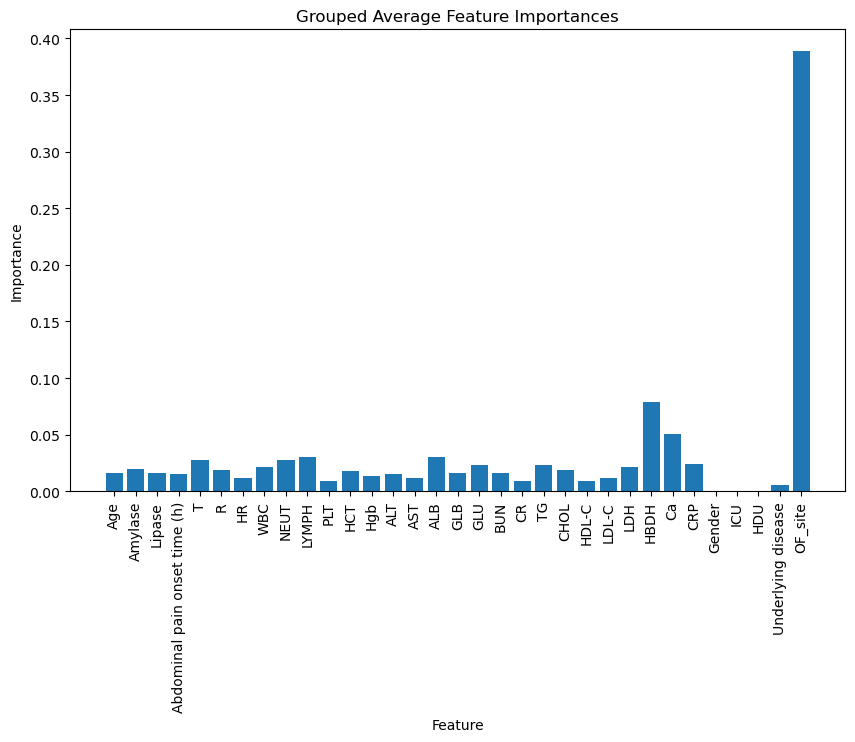

In [11]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

model = XGBClassifier(booster='gbtree', learning_rate=0.1, max_depth=3, n_estimators=50)
sum_feature_importances = None
feature_names = None

for dataset in datasets:
    X_train, y_train, X_test, y_test = dataset['X_train'].drop(['OF'], axis=1), dataset['y_train'], dataset['X_test'].drop(['OF'], axis=1), dataset['y_test']

    # Train the model
    model.fit(X_train, y_train)

    # Initialize feature names and sum_feature_importances
    if feature_names is None:
        feature_names = X_train.columns
        sum_feature_importances = np.zeros(len(feature_names))

    # Sum the feature importances
    sum_feature_importances += model.feature_importances_

# Calculate the average feature importances
average_feature_importances = sum_feature_importances / len(datasets)

# Group the feature importances of one-hot encoded features
grouped_importances = {}
for name, importance in zip(feature_names, average_feature_importances):
    if 'Underlying disease_' in name:
        base_name = 'Underlying disease'
        grouped_importances[base_name] = grouped_importances.get(base_name, 0) + importance
    elif 'OF_site_' in name:
        base_name = 'OF_site'
        grouped_importances[base_name] = grouped_importances.get(base_name, 0) + importance
    else:
        grouped_importances[name] = importance

# Visualize the grouped feature importances
plt.figure(figsize=(10, 6))
plt.title('Grouped Average Feature Importances')
plt.bar(grouped_importances.keys(), grouped_importances.values())
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()


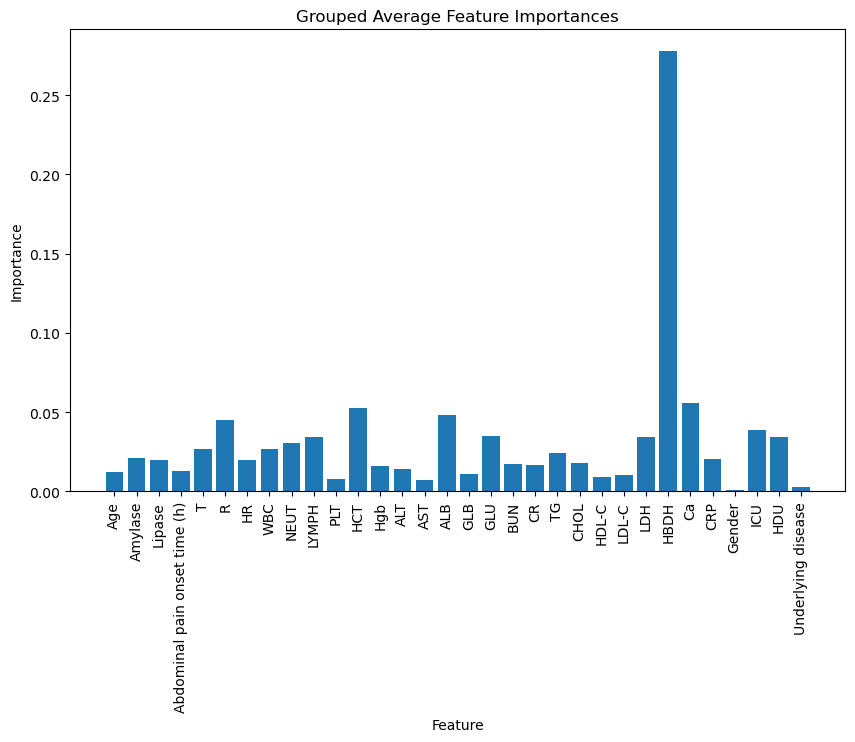

In [12]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

model = XGBClassifier(booster='gbtree', learning_rate=0.1, max_depth=3, n_estimators=50)
sum_feature_importances = None
feature_names = None

for dataset in datasets:
    X_train, y_train, X_test, y_test = dataset['X_train'].drop(['OF','OF_site_0','OF_site_1','OF_site_2','OF_site_3'], axis=1), dataset['y_train'], dataset['X_test'].drop(['OF','OF_site_0','OF_site_1','OF_site_2','OF_site_3'], axis=1), dataset['y_test']

    # Train the model
    model.fit(X_train, y_train)

    # Initialize feature names and sum_feature_importances
    if feature_names is None:
        feature_names = X_train.columns
        sum_feature_importances = np.zeros(len(feature_names))

    # Sum the feature importances
    sum_feature_importances += model.feature_importances_

# Calculate the average feature importances
average_feature_importances = sum_feature_importances / len(datasets)

# Group the feature importances of one-hot encoded features
grouped_importances = {}
for name, importance in zip(feature_names, average_feature_importances):
    if 'Underlying disease_' in name:
        base_name = 'Underlying disease'
        grouped_importances[base_name] = grouped_importances.get(base_name, 0) + importance
    elif 'OF_site_' in name:
        base_name = 'OF_site'
        grouped_importances[base_name] = grouped_importances.get(base_name, 0) + importance
    else:
        grouped_importances[name] = importance

# Visualize the grouped feature importances
plt.figure(figsize=(10, 6))
plt.title('Grouped Average Feature Importances')
plt.bar(grouped_importances.keys(), grouped_importances.values())
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()
